<a href="https://colab.research.google.com/github/ss-leg-al/ML_DeliveryTime/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from google.colab import drive
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn import svm

import datetime
import random
import os

import seaborn
import copy

from sklearn.model_selection import GridSearchCV 
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
import sklearn.metrics as metrics

drive.mount('/content/drive')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
time_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Sample_Submission.csv')
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

Mounted at /content/drive


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [ ]:
print(train)

            ID Delivery_person_ID Delivery_person_Age Delivery_person_Ratings  \
0      0x4607     INDORES13DEL02                   37                     4.9   
1      0xb379     BANGRES18DEL02                   34                     4.5   
2      0x5d6d     BANGRES19DEL01                   23                     4.4   
3      0x7a6a    COIMBRES13DEL02                   38                     4.7   
4      0x70a2     CHENRES12DEL01                   32                     4.6   
...        ...                ...                 ...                     ...   
45588  0x7c09      JAPRES04DEL01                   30                     4.8   
45589  0xd641      AGRRES16DEL01                   21                     4.6   
45590  0x4f8d     CHENRES08DEL03                   30                     4.9   
45591  0x5eee    COIMBRES11DEL01                   20                     4.7   
45592  0x5fb2   RANCHIRES09DEL02                   23                     4.9   

       Restaurant_latitude 

In [ ]:
# 불필요한 부분 일부 slicing('Weatherconditions','Time_taken(min)','Order_Date','Time_Orderd','Time_Order_picked')

train['Weatherconditions'] = train['Weatherconditions'].map(lambda x: str(x)[11:])
train['Time_taken(min)'] = train['Time_taken(min)'].map(lambda x: str(x)[6:])
train['Order_Date'] = train['Order_Date'].map(lambda x: str(x)[3:5])
train['Time_Orderd'] = train['Time_Orderd'].map(lambda x: str(x)[:5])
train['Time_Order_picked'] = train['Time_Order_picked'].map(lambda x: str(x)[:5])


test['Weatherconditions'] = test['Weatherconditions'].map(lambda x: str(x)[11:])
test['Order_Date'] = train['Order_Date'].map(lambda x: str(x)[3:5])
test['Time_Orderd'] = test['Time_Orderd'].map(lambda x: str(x)[:5])
test['Time_Order_picked'] = test['Time_Order_picked'].map(lambda x: str(x)[:5])

# datatype 변경

to_be_float=['Delivery_person_Age', 'Delivery_person_Ratings','Vehicle_condition','Time_taken(min)']
for i in to_be_float:
  train[i]=train[i].astype(float)
for i in to_be_float[:-1]:
  test[i]=test[i].astype(float)

train=train.replace('NaN',np.nan,regex=True)
test=test.replace('NaN',np.nan,regex=True)

ID                               0
Delivery_person_ID               0
Delivery_person_Age              0
Delivery_person_Ratings          0
Restaurant_latitude              0
Restaurant_longitude             0
Delivery_location_latitude       0
Delivery_location_longitude      0
Order_Date                       0
Time_Orderd                    444
Time_Order_picked                0
Weatherconditions                0
Road_traffic_density             0
Vehicle_condition                0
Type_of_order                    0
Type_of_vehicle                  0
multiple_deliveries              0
Festival                         0
City                             0
dtype: int64

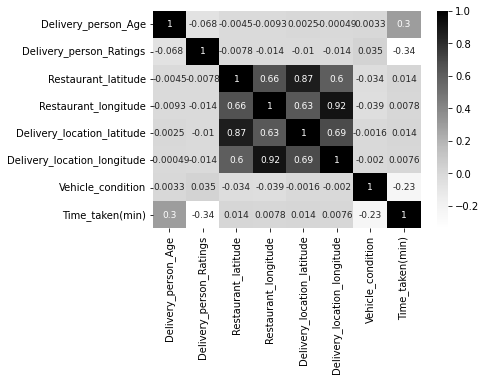

In [ ]:
# missing value 채우기 

# 1. continuous values (선형회귀로 채우기)

a=train.loc[:,['Delivery_person_Ratings','Vehicle_condition','Delivery_person_Age']]
seaborn.heatmap(train.corr(),annot=True,annot_kws={"size": 9},cmap='Greys')

lin_reg=linear_model.LinearRegression()
x=test.dropna(axis=0)[['Delivery_person_Ratings','Vehicle_condition']]
y=test.dropna(axis=0)[['Delivery_person_Age']]
lin_reg_model_Age=lin_reg.fit(x,y)

train_mean_ratings=train['Delivery_person_Ratings'].mean()
test_mean_ratings=test['Delivery_person_Ratings'].mean()
tmp_train=copy.deepcopy(train)
tmp_test=copy.deepcopy(test)
tmp_train['Delivery_person_Ratings'].fillna(train_mean_ratings,inplace=True)
tmp_test['Delivery_person_Ratings'].fillna(test_mean_ratings,inplace=True)

Age_pred_train=lin_reg_model_Age.predict(tmp_train.loc[:,['Delivery_person_Ratings','Vehicle_condition']])
train['Delivery_person_Age'].fillna(pd.Series(Age_pred_train.flatten()), inplace=True)
Age_pred_test=lin_reg_model_Age.predict(tmp_test.loc[:,['Delivery_person_Ratings','Vehicle_condition']])
test['Delivery_person_Age'].fillna(pd.Series(Age_pred_test.flatten()), inplace=True)

x=test.dropna(axis=0)[['Delivery_person_Age','Vehicle_condition']]
y=test.dropna(axis=0)[['Delivery_person_Ratings']]
lin_reg_model_Ratings=lin_reg.fit(x,y)

Ratings_pred_train=lin_reg_model_Ratings.predict(train.loc[:,['Delivery_person_Age','Vehicle_condition']])
train['Delivery_person_Ratings'].fillna(pd.Series(Ratings_pred_train.flatten()), inplace=True)
Ratings_pred_test=lin_reg_model_Ratings.predict(test.loc[:,['Delivery_person_Age','Vehicle_condition']])
test['Delivery_person_Ratings'].fillna(pd.Series(Ratings_pred_test.flatten()), inplace=True)

# 2. discrete values (최빈값으로 채우기)

to_be_filled=['Weatherconditions','Road_traffic_density','City','multiple_deliveries','Festival']
for i in to_be_filled:
  train[i]=train[i].fillna(train[i].mode()[0])
  test[i]=test[i].fillna(test[i].mode()[0])

test.isnull().sum()

In [ ]:
# 범주형 데이터 수치화 (label encoding)
def categorical_to_numeric(data):

  for label,content in data.items():
      if not pd.api.types.is_numeric_dtype(content):
          data[label]=pd.Categorical(content).codes+1

In [ ]:
# 새로운 feature 생성

# time_cook
def cooktime(data):
  new_data_picked = data['Time_Order_picked'].str.replace(r'\D', '',regex=True).astype(int)

  new_data_order = data['Time_Orderd'].fillna('0')
  new_data_order= new_data_order.str.replace(r'\D', '',regex=True).astype(int)

  min_data_order = (new_data_order % 100) + ((new_data_order // 100) * 60)
  min_data_picked = (new_data_picked % 100) + ((new_data_picked // 100) * 60) + 1440

  T = zip(min_data_order, min_data_picked)
  count=0
  sum = 0

  for (i, j) in T:
    if i != 0:
      count+=1
      sum += ((j-i)%1440)

  mean = sum / count

  T = zip(min_data_order, min_data_picked)
  result = []

  for (i, j) in T:
    if i != 0:
      result.append((j-i)%1440)
    else:
      result.append(int(mean))

  return result

# distance
def haversine_distance(data):
    coord1 = data['Restaurant_latitude'],data['Restaurant_longitude']
    coord2 = data['Delivery_location_latitude'],data['Delivery_location_longitude']
    R = 6372.8  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = np.radians(lat1), np.radians(lat2) 
    dphi       = np.radians(lat2 - lat1)
    dlambda    = np.radians(lon2 - lon1)
    
    a = (np.sin(dphi/2)**2) + np.cos(phi1)*np.cos(phi2)*(np.sin(dlambda/2)**2)
    
    distance = 2*R*np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return distance

In [ ]:
train['time_cook']=cooktime(train)
test['time_cook']=cooktime(test)

train['distance'] = haversine_distance(train)
test['distance'] = haversine_distance(test)

categorical_to_numeric(train)
categorical_to_numeric(test)

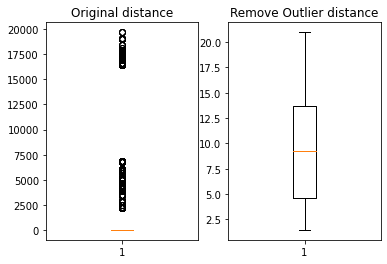

In [ ]:
# 'distance'의 outlier 탐지

fig = plt.figure()
fig_origin = fig.add_subplot(1,2,1) 
fig_origin.set_title('Original distance')
fig_origin.boxplot(train['distance'])

data = train['distance']

IQR_val = np.percentile(data,75) - np.percentile(data,25)

upper_fense = np.percentile(data,75) + 1.5 * IQR_val
lower_fense = np.percentile(data,25) - 1.5 * IQR_val

result = data[(data <= upper_fense) & (data >= lower_fense)]

train['distance']= result

fig_result = fig.add_subplot(1,2,2) 
fig_result.set_title('Remove Outlier distance')
fig_result.boxplot(result)

plt.show()

df = train
result = df.dropna(axis=0)
train = result

In [ ]:
# train set 전처리
c_train = train.drop(['ID','Delivery_person_ID','Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude','Time_Orderd','Time_Order_picked'], axis=1)

x = c_train.drop('Time_taken(min)', axis=1)
y = c_train['Time_taken(min)']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, random_state=123)

# test set 전처리
ID = test.ID
c_test = test.drop(['ID','Delivery_person_ID','Restaurant_latitude','Restaurant_longitude','Delivery_location_latitude','Delivery_location_longitude','Time_Orderd','Time_Order_picked'], axis=1)
real_time = time_test.drop('ID', axis=1)

# Regression (before final)

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror')
xgb_model.fit(x_train,y_train,verbose=False)

# r-squared score; training set
xgb_pred = xgb_model.predict(x_train)
score = r2_score(y_train,xgb_pred)
print('xgb : r2score(training) = ', score)

# r-squared score; validation set
xgb_pred = xgb_model.predict(x_valid)
score = r2_score(y_valid,xgb_pred)
print('xgb : r2score(validation) = ', score)

# r-squared score; test set
xgb_pred = xgb_model.predict(c_test)
score = r2_score(real_time,xgb_pred)
print('xgb : r2score(test) = ', score)

xgb : r2score(training) =  0.7797407296268394
xgb : r2score(validation) =  0.7801149945895349
xgb : r2score(test) =  0.9019552769179977


In [ ]:
# root mean squared log error; test set
rmsle = mean_squared_log_error(real_time, xgb_pred) ** 0.5
print('xgb : rmsle(test) = ', rmsle)

# mean absolute percentage error; test set
mape = mean_absolute_percentage_error(real_time, xgb_pred)
print('xgb : mape(test) = ', mape)

xgb : rmsle(test) =  0.10606176006800168
xgb : mape(test) =  0.08303507321783239


In [ ]:
# lasso_model=linear_model.LassoLars(alpha=.1, normalize=False)
# lasso_model.fit(x_train,y_train)

# #r-squared score; training set
# lasso_preds=lasso_model.predict(x_train)
# score = r2_score(y_train,lasso_preds)
# print('lasso : r2score(training) = ', score)

# #r-squared score; validation set
# lasso_preds=lasso_model.predict(x_valid)
# score=r2_score(y_valid,lasso_preds)
# print('lasso : r2score(validation) = ', score)

# #r-squared score; test set
# lasso_preds=lasso_model.predict(c_test)
# score=r2_score(real_time,lasso_preds)
# print('lasso : r2score(test) = ', score)

In [ ]:
# rmsle = mean_squared_log_error(real_time, lasso_preds) ** 0.5
# print('lasso : rmsle(test) = ', rmsle)

# #mean absolute percentage error; test set
# mape = mean_absolute_percentage_error(real_time, lasso_preds)
# print('lasso : mape(test) = ', mape)

# Performance improvement

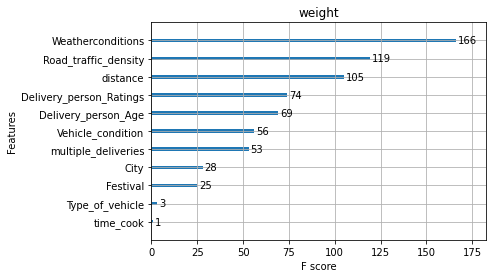

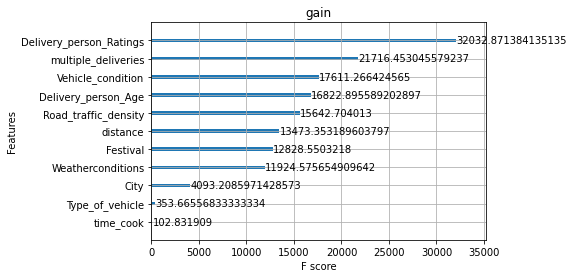

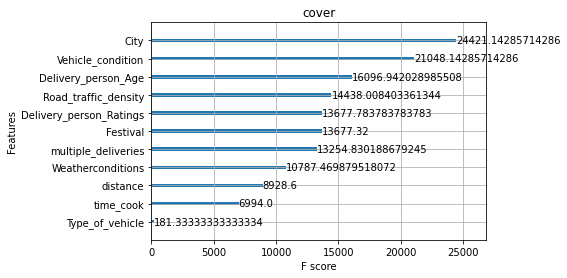

In [ ]:
xgb.plot_importance(xgb_model, importance_type = 'weight', title = 'weight')
xgb.plot_importance(xgb_model, importance_type = 'gain', title ='gain')
xgb.plot_importance(xgb_model, importance_type = 'cover', title = 'cover')

In [ ]:
# train set
c_train = c_train.drop(['Type_of_order', 'Type_of_vehicle', 'Order_Date','time_cook'], axis=1)

x = c_train.drop('Time_taken(min)', axis=1)
y = c_train['Time_taken(min)']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, train_size=0.7, random_state=123)

# test set
ID = test.ID
c_test = c_test.drop(['Type_of_order', 'Type_of_vehicle', 'Order_Date','time_cook'], axis=1)
real_time = time_test.drop('ID', axis=1)

In [ ]:
now = datetime.datetime.now()

# Various hyper-parameters to tune
xgb1 = XGBRegressor()
parameters = {'nthread':[4], 
              'objective':['reg:squarederror'],
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 9 candidates, totalling 18 fits
0.8196010675393814
{'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:squarederror', 'silent': 1, 'subsample': 0.7}


In [ ]:
# r-squared score; training set
tuned_pred = xgb_grid.predict(x_train)
score = r2_score(y_train,tuned_pred)
print('tuned : r2score(training) = ', score)
 
# r-squared score; validation set
tuned_pred = xgb_grid.predict(x_valid)
score = r2_score(y_valid,tuned_pred)
print('tuned : r2score(validation) = ', score)
 
# r-squared score; test set
tuned_pred = xgb_grid.predict(c_test)
score = r2_score(real_time,tuned_pred)
print('tuned : r2score(test) = ', score)

tuned : r2score(training) =  0.8572711537498117
tuned : r2score(validation) =  0.8271304103846366
tuned : r2score(test) =  0.9381385324351174


In [ ]:
# root mean squared log error; test set
rmsle = mean_squared_log_error(real_time, tuned_pred) ** 0.5
print('tuned : rmsle(test) = ', rmsle)
 
# mean absolute percentage error; test set
mape = mean_absolute_percentage_error(real_time, tuned_pred)
print('tuned : mape(test) = ', mape)

tuned : rmsle(test) =  0.08180783292999873
tuned : mape(test) =  0.06030761501570238


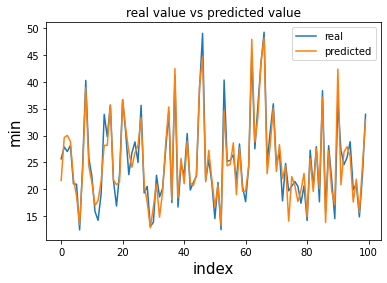

In [ ]:
# 실제값과 예측값 차이
x_ax = range(100)
plt.plot(x_ax, real_time[:100], label="real")
plt.plot(x_ax, xgb_pred[:100], label="predicted")
plt.title("real value vs predicted value")
plt.ylabel('min',size=15)
plt.xlabel('index',size=15)

plt.legend()
plt.show()